Week 9 · Day 2 — RNN Basics & Vanishing/Exploding Gradients
Why this matters

Recurrent Neural Networks (RNNs) are the foundation for modeling sequential data like text. But they suffer from vanishing/exploding gradients, which explains why LSTMs and GRUs were invented.

Theory Essentials

RNN intuition: processes sequences one step at a time, maintaining a hidden state.

Hidden state: carries information across time steps.

Vanishing gradients: long sequences → gradients shrink toward zero → poor learning.

Exploding gradients: gradients blow up exponentially → unstable training.

Gradient clipping: caps gradient norms to stabilize training.

Why it matters: understanding this explains the need for LSTMs/GRUs later.


### 🔹 What are RNNs?

**Recurrent Neural Networks (RNNs)** are a class of neural nets designed for **sequential data** (text, time series, audio, etc.).

* Instead of processing all inputs independently (like an MLP), RNNs process one timestep at a time and **pass hidden state forward**.
* At each step:

  ```
  h_t = f(Wx_t + Uh_(t-1))
  ```

  where `h_t` is the hidden state at step `t`, combining:

  * **current input (x\_t)**
  * **previous hidden state (h\_(t-1))**

So the RNN has **memory**: later predictions depend on earlier tokens.

👉 Applications: text classification, speech recognition, stock prediction, etc.

--

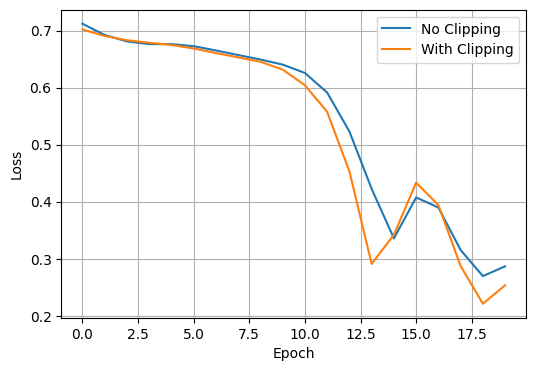

In [18]:
# Setup
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
np.random.seed(42)
plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["axes.grid"] = True

import torch
import torch.nn as nn
import torch.optim as optim

# Toy dataset: classify if sequence sum > threshold
def make_dataset(n=200, seq_len=10):
    X, y = [], []
    for _ in range(n):
        seq = np.random.randint(0, 2, size=seq_len)
        X.append(seq)
        y.append(int(seq.sum() > (seq_len//2)))
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y)

X, y = make_dataset(300, seq_len=15)
train_X, train_y = X[:200], y[:200]
val_X, val_y = X[200:], y[200:]

# RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=16):
        super().__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 2)
    def forward(self, x):
        x = x.unsqueeze(-1) # add feature dim
        out, h = self.rnn(x)
        return self.fc(out[:,-1,:])  # last hidden state


criterion = nn.CrossEntropyLoss()

# Training loop
def train(model, X, y, clip=False):
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    losses = []
    for epoch in range(20):
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        if clip:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        losses.append(loss.item())
    return losses

losses_no_clip = train(SimpleRNN(), train_X, train_y, clip=False)


losses_clip = train(SimpleRNN(), train_X, train_y, clip=True)

plt.plot(losses_no_clip, label="No Clipping")
plt.plot(losses_clip, label="With Clipping")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


1) Core (10–15 min)
Task: Print the gradient norm each epoch (before and after clipping).

In [20]:
def grad_norm(params):
    # global L2 norm (same definition used by clip_grad_norm_)
    norms = [p.grad.detach().norm(2) for p in params if p.grad is not None]
    return torch.norm(torch.stack(norms), 2).item() if norms else 0.0

model = SimpleRNN()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(5):   # just 5 epochs to demo
    optimizer.zero_grad()
    out = model(train_X)
    loss = criterion(out, train_y)
    loss.backward()

    gnorm = grad_norm(model.parameters())
    print(f"Epoch {epoch+1}: grad norm = {gnorm:.4f}")

    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # optional
    optimizer.step()


Epoch 1: grad norm = 0.3303
Epoch 2: grad norm = 0.1420
Epoch 3: grad norm = 0.1041
Epoch 4: grad norm = 0.2033
Epoch 5: grad norm = 0.2386


👉 If the norm ever exceeds 1.0, you’ll see clipping reduce it after the call. If it’s always below, then clipping won’t change it — which is expected for your short toy task.

2) Practice (10–15 min)
Task: Increase seq_len to 50 in the toy dataset. Compare training stability with and without gradient clipping.

🔹 What seq_len does

It sets the length of each sequence.

Example:

seq_len=5 → each input looks like [0,1,0,1,1].

seq_len=15 → each input looks like [1,0,0,1,1,0,1,0,1,1,0,0,1,0,1].

So it’s the number of timesteps the RNN will unroll through.

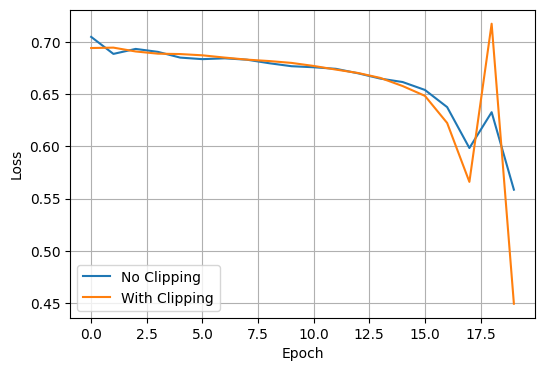

In [22]:
X, y = make_dataset(300, seq_len=50)
train_X, train_y = X[:200], y[:200]
losses_long_normal = train(SimpleRNN(), train_X, train_y, clip=False)
losses_long_clip = train(SimpleRNN(), train_X, train_y, clip=False)

plt.plot(losses_long_normal, label="No Clipping")
plt.plot(losses_long_clip, label="With Clipping")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


3) Stretch (optional, 10–15 min)
Task: Try different hidden sizes (e.g., 8 vs 64). Which one suffers more from unstable gradients?

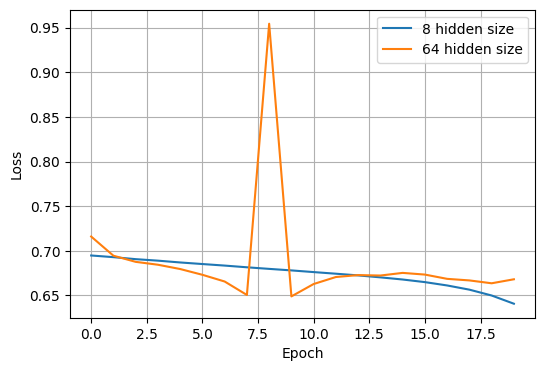

In [26]:
losses_diff_sizes = []

for h in [8,64]:
    model = SimpleRNN(hidden_dim=h)
    losses = train(model, train_X, train_y)
    losses_diff_sizes.append(losses)


plt.plot(losses_diff_sizes[0], label="8 hidden size")
plt.plot(losses_diff_sizes[1], label="64 hidden size")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


Mini-Challenge (≤40 min)

Build & analyze:

Train RNN on sequences of length 30.

Track training loss curves with and without gradient clipping.

Acceptance Criteria: Plot shows divergence without clipping, stability with clipping.

Bonus: print 3 misclassified examples.

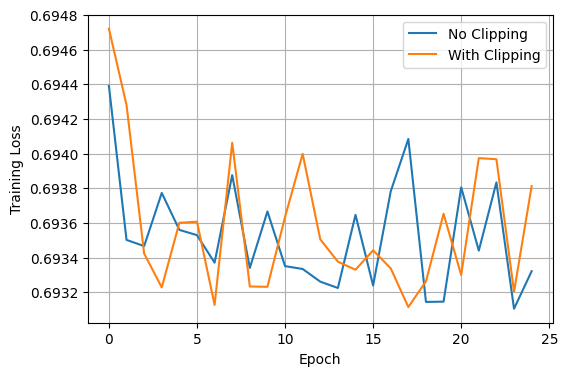

Validation accuracy (clipped): 0.486

Misclassified #1
Seq: [0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0]
Label: 1  Pred: 0   (first==last? -> 1 )

Misclassified #2
Seq: [0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0]
Label: 1  Pred: 0   (first==last? -> 1 )

Misclassified #3
Seq: [1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1]
Label: 1  Pred: 0   (first==last? -> 1 )


In [30]:
# Mini-Challenge — RNN on seq_len=30 with/without gradient clipping
# Setup (deterministic-ish)
import random, numpy as np, torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
random.seed(42); np.random.seed(42); torch.manual_seed(42)

# ---------- 1) Dataset ----------
# Long-range dependency: label = 1 if first bit equals last bit, else 0
def make_dataset(n=6000, seq_len=30):
    X = np.random.randint(0, 2, size=(n, seq_len)).astype(np.float32)
    y = (X[:, 0] == X[:, -1]).astype(np.int64)
    return torch.tensor(X), torch.tensor(y)

seq_len = 30
X, y = make_dataset(8000, seq_len=seq_len)
train_X, train_y = X[:6000], y[:6000]
val_X,   val_y   = X[6000:], y[6000:]

train_loader = DataLoader(TensorDataset(train_X, train_y), batch_size=128, shuffle=True)
val_loader   = DataLoader(TensorDataset(val_X,   val_y),   batch_size=512, shuffle=False)

# ---------- 2) Model ----------
class SimpleRNN(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, nonlinearity="relu"):
        super().__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True, nonlinearity=nonlinearity)
        self.fc  = nn.Linear(hidden_dim, 2)
    def forward(self, x):
        x = x.unsqueeze(-1)            # [B, T, 1]
        out, _ = self.rnn(x)           # [B, T, H]
        last = out[:, -1, :]           # last time step
        return self.fc(last)           # [B, 2]

criterion = nn.CrossEntropyLoss()

# ---------- 3) Train/Eval helpers ----------
def train_one(model, loader, epochs=25, lr=1e-2, clip=False, clip_norm=1.0):
    opt = optim.Adam(model.parameters(), lr=lr)
    losses = []
    for _ in range(epochs):
        model.train()
        epoch_loss = 0.0
        for xb, yb in loader:
            opt.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            if clip:
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_norm)
            opt.step()
            epoch_loss += loss.item() * xb.size(0)
        losses.append(epoch_loss / len(loader.dataset))
    return losses, model

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    preds_all, ys_all, xs_all = [], [], []
    for xb, yb in loader:
        logits = model(xb)
        pred = logits.argmax(dim=1)
        correct += (pred == yb).sum().item()
        total   += yb.numel()
        preds_all.append(pred.cpu())
        ys_all.append(yb.cpu())
        xs_all.append(xb.cpu())
    return correct / total, torch.cat(preds_all), torch.cat(ys_all), torch.cat(xs_all)

# ---------- 4) Runs: no-clip vs clip ----------
model_nc = SimpleRNN()
loss_nc, model_nc = train_one(model_nc, train_loader, epochs=25, lr=0.02, clip=False)

model_c  = SimpleRNN()
loss_c,  model_c  = train_one(model_c,  train_loader, epochs=25, lr=0.02, clip=True, clip_norm=1.0)

# ---------- 5) Plot curves ----------
plt.plot(loss_nc, label="No Clipping")
plt.plot(loss_c,  label="With Clipping")
plt.xlabel("Epoch"); plt.ylabel("Training Loss"); plt.legend(); plt.show()

# ---------- 6) Bonus: print 3 misclassified examples (from clipped model) ----------
acc, preds, ys, xs = evaluate(model_c, val_loader)
print(f"Validation accuracy (clipped): {acc:.3f}")

mis_idx = (preds != ys).nonzero().flatten().tolist()[:3]
for i, idx in enumerate(mis_idx, 1):
    seq = xs[idx].numpy().astype(int).tolist()
    print(f"\nMisclassified #{i}")
    print("Seq:", seq)
    print("Label:", int(ys[idx].item()), " Pred:", int(preds[idx].item()),
          "  (first==last? ->", int(seq[0]==seq[-1]), ")")


Notes / Key Takeaways

RNNs process data sequentially using hidden states.

They struggle with long sequences → gradients vanish or explode.

Gradient clipping stabilizes training but does not fully solve the problem.

Hidden size affects gradient behavior.

This limitation motivated LSTM and GRU designs.

Today’s toy dataset mimics classification over sequences.

Tomorrow we’ll explore how LSTMs/GRUs fix these issues.

Reflection

Why does gradient clipping help with exploding gradients?

How would vanishing gradients affect the RNN’s ability to learn dependencies?

Why does gradient clipping help with exploding gradients?
Exploding gradients happen when backpropagated updates become extremely large, causing unstable jumps in weight values and divergence. Gradient clipping sets a maximum norm for the gradients: if they exceed this threshold, they’re scaled down. This prevents extreme updates, stabilizes training, and keeps the optimization process under control.

How would vanishing gradients affect the RNN’s ability to learn dependencies?
Vanishing gradients shrink toward zero as they’re propagated through many timesteps. In RNNs, this means early inputs in a long sequence hardly affect the weight updates. As a result, the RNN struggles to learn long-term dependencies, essentially “forgetting” information from earlier in the sequence and only focusing on the most recent tokens.